### Random Forest and GBDT on Amazon reviews data set

In [1]:
#importing required Modules
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier as RF
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
conn = sqlite3.connect('final_clean_dt1.sqlite')
final_review = pd.read_sql_query("""
SELECT *
FROM Reviews_final
""", conn) 

In [3]:
#SORT by time for TBS
final_review = final_review.sort_values(by='Time')

In [4]:
final_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 23 to 345187
Data columns (total 6 columns):
index                     364171 non-null int64
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null object
final_text                364171 non-null object
Time                      364171 non-null int64
dtypes: int64(4), object(2)
memory usage: 19.4+ MB


In [5]:
#changing lables to 1 or 0
final_review.Score = final_review.Score.apply(lambda x:
                     1 if x == 'positive' else 0)

In [6]:
#Converting to int8
final_review.HelpfulnessNumerator = final_review.\
                      HelpfulnessNumerator.astype(np.int8)
final_review.HelpfulnessDenominator = final_review.\
                      HelpfulnessDenominator.astype(np.int8)

In [7]:
#Splitting Dataframe for train and test
train_df = final_review.iloc[:round(final_review.shape[0]*0.70),:]
test_df = final_review.iloc[round(final_review.shape[0]*0.70):,:]

In [8]:
train_df.to_csv('train_df_dt.csv',index=False)
test_df.to_csv('test_df_dt.csv',index=False)

In [8]:
print(train_df.shape)
print(test_df.shape)

(254920, 6)
(109251, 6)


#### Word2Vec

In [10]:
#importing
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim

In [10]:
import gensim
list_of_sent=[]
for sent in final_review.final_text.values:
    list_of_sent.append(sent.split())

In [12]:
#word2vec model with 300 dim vector
w2v_model_300=gensim.models.Word2Vec(list_of_sent,min_count=5,size=300, workers=8)

In [ ]:
pickle.dump(w2v_model_50,open('w2v_model_dt_50.p','wb'))

In [11]:
w2v_model_300 = pickle.load(open('w2v_model_dt_300.p','rb'))

#### Avg Word2Vec

In [11]:
# the avg-w2v for each sentence/review is stored in this list
def avg_w2v(list_of_sent,model,d):
    '''
    Returns average of word vectors for 
    each sentance with dimension of model given
    '''
    sent_vectors = []
    for sent in list_of_sent: # for each review/sentence
        doc = [word for word in sent if word in model.wv.vocab]
        if doc:
            sent_vec = np.mean(model.wv[doc],axis=0)
        else:
            sent_vec = np.zeros(d)
        sent_vectors.append(sent_vec)
    return sent_vectors

In [13]:
list_of_sent_train=[]
for sent in train_df.final_text.values:
    list_of_sent_train.append(sent.split())

In [15]:
#avg word2vec for 
sent_vector_avgw2v_300 = avg_w2v(list_of_sent_train,w2v_model_300,300)
#stacking columns
train_avgw2v_300 = np.hstack((sent_vector_avgw2v_300,
            train_df[['HelpfulnessNumerator','HelpfulnessDenominator','Score']]))
column = list(range(0,300))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator','Score'])
train_df_avgw2v_300 = pd.DataFrame(train_avgw2v_300,columns=column)

In [15]:
train_df_avgw2v_300.to_csv('train_df_avgw2v_300.csv',index=False)

In [16]:
X_train = train_df_avgw2v_300.iloc[:round(train_df.shape[0]*0.70),:]
X_test_cv = train_df_avgw2v_300.iloc[round(train_df.shape[0]*0.70):,:]

##### Random Forest

In [18]:
#base model
model = RF(n_jobs=-1,random_state=25).fit(X_train.drop('Score',axis=1),X_train.Score)
#train score
train_score = model.score(X_train.drop('Score',axis=1),X_train.Score)
#test score
test_score = model.score(X_test_cv.drop('Score',axis=1),X_test_cv.Score)
print('Train Score',train_score)
print('Test Score',test_score)

Train Score 0.9969738405326041
Test Score 0.8889847795386788


In [26]:
for i in range(1,20):
    model = RF(n_estimators=i,n_jobs=-1,random_state=25)
    model.fit(X_train.drop('Score',axis=1),X_train.Score)
    #train score
    train_score = model.score(X_train.drop('Score',axis=1),X_train.Score)
    #test score
    test_score = model.score(X_test_cv.drop('Score',axis=1),X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 1 Train Score 0.9415558942861626 Test Score 0.8301035619017731
No of Estimators 2 Train Score 0.9352457913967407 Test Score 0.8022255348083058
No of Estimators 3 Train Score 0.9776400439353523 Test Score 0.8654610596788535
No of Estimators 4 Train Score 0.982403443096994 Test Score 0.8622312882472932
No of Estimators 5 Train Score 0.9876543901728273 Test Score 0.8755557299021915
No of Estimators 6 Train Score 0.9920199054044967 Test Score 0.8789554893038339
No of Estimators 7 Train Score 0.992031113402524 Test Score 0.881283016894189
No of Estimators 8 Train Score 0.9953038488265226 Test Score 0.8853627281761598
No of Estimators 9 Train Score 0.9945473089596736 Test Score 0.8842251163763796
No of Estimators 10 Train Score 0.9969738405326041 Test Score 0.8889847795386788
No of Estimators 11 Train Score 0.9958754567259196 Test Score 0.8864872639782415
No of Estimators 12 Train Score 0.9978648763757818 Test Score 0.8898085673936922
No of Estimators 13 Train Score 0.997007

In [47]:
#grid search
param_grid = {'n_estimators':[1,3,5,7,9,11,15,17,19,21,25,27,35]}
model_grid_avgw2v = GridSearchCV(RF(n_jobs=-1,random_state=25),param_grid=param_grid,
                     cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_grid_avgw2v.fit(train_df_avgw2v_300.drop('Score',axis=1),train_df_avgw2v_300.Score)

In [50]:
dict_scores = []
idx = 0
for i in model_grid_avgw2v.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['n_estimators'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_grid_avgw2v.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['n_estimators','Test_score',
                                               'Test_std','Train_score'])

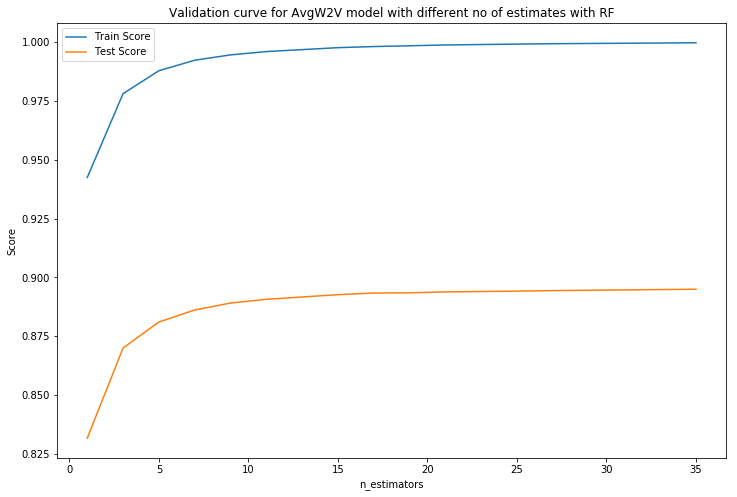

In [55]:
plt.figure(figsize=(12,8))
plt.plot(scores_df.n_estimators,scores_df.Train_score,label='Train Score')
plt.plot(scores_df.n_estimators,scores_df.Test_score,label='Test Score')
plt.title('Validation curve for AvgW2V model with different no of estimates with RF')
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.legend()

In [56]:
scores_df

,n_estimators,Test_score,Test_std,Train_score
0,1,0.831742,0.010920,0.942438
1,3,0.870001,0.009861,0.978063
2,5,0.881069,0.008450,0.987786
3,7,0.886157,0.008190,0.992247
4,9,0.889126,0.008104,0.994517
5,11,0.890701,0.008086,0.995924
6,15,0.892673,0.007981,0.997590
7,17,0.893368,0.007743,0.998058
8,19,0.893450,0.007841,0.998393
9,21,0.893847,0.007564,0.998735


We can observe that after no of estimates >15 there is no increment in test score. and that is also having some varince. 

In [53]:
print('with 15 estimaters')
for i in range(1,20):
    model = RF(n_estimators=15,max_depth=i,n_jobs=-1,random_state=25)
    model.fit(X_train.drop('Score',axis=1),X_train.Score)
    #train score
    train_score = model.score(X_train.drop('Score',axis=1),X_train.Score)
    #test score
    test_score = model.score(X_test_cv.drop('Score',axis=1),X_test_cv.Score)
    print('Deptha',i,'Train Score',train_score,'Test Score',test_score)

with 15 estimaters
Deptha 1 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Deptha 2 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Deptha 3 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Deptha 4 Train Score 0.8639349039474569 Test Score 0.8333333333333334
Deptha 5 Train Score 0.8719206025419739 Test Score 0.8425257597154663
Deptha 6 Train Score 0.8788247293268476 Test Score 0.8511166902034625
Deptha 7 Train Score 0.886177176032817 Test Score 0.8588707568387468
Deptha 8 Train Score 0.8944598865750599 Test Score 0.8674355353313458
Deptha 9 Train Score 0.9033534330097958 Test Score 0.8727836183900831
Deptha 10 Train Score 0.9147743829997086 Test Score 0.8787331973429573
Deptha 11 Train Score 0.9260160050211831 Test Score 0.880485381034573
Deptha 12 Train Score 0.9396113066284101 Test Score 0.8837020764684346
Deptha 13 Train Score 0.9517159444979938 Test Score 0.8841335843924891
Deptha 14 Train Score 0.9629127345273587 Test Score 0.886644175950625

In [54]:
print('with 25 estimaters')
for i in range(1,20):
    model = RF(n_estimators=25,max_depth=i,n_jobs=-1,random_state=25)
    model.fit(X_train.drop('Score',axis=1),X_train.Score)
    #train score
    train_score = model.score(X_train.drop('Score',axis=1),X_train.Score)
    #test score
    test_score = model.score(X_test_cv.drop('Score',axis=1),X_test_cv.Score)
    print('Deptha',i,'Train Score',train_score,'Test Score',test_score)

with 25 estimaters
Deptha 1 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Deptha 2 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Deptha 3 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Deptha 4 Train Score 0.8630550761023066 Test Score 0.8325749254668131
Deptha 5 Train Score 0.8706316827688239 Test Score 0.8420550237983158
Deptha 6 Train Score 0.8776703055300262 Test Score 0.8509205502379832
Deptha 7 Train Score 0.8856279841294747 Test Score 0.8591061247973221
Deptha 8 Train Score 0.8937818026944028 Test Score 0.8674355353313458
Deptha 9 Train Score 0.9035383649772477 Test Score 0.8730974423348502
Deptha 10 Train Score 0.9145222030440923 Test Score 0.8788378053245463
Deptha 11 Train Score 0.9269518728564704 Test Score 0.881492232857367
Deptha 12 Train Score 0.9404855304745466 Test Score 0.8842381923740782
Deptha 13 Train Score 0.9533691242070341 Test Score 0.8860296040587897
Deptha 14 Train Score 0.9644818542511937 Test Score 0.88711491186777

In [16]:
print('with 25 estimaters')
for i in range(1,20):
    model = RF(n_estimators=25,max_depth=i,max_features='log2',n_jobs=-1,random_state=25)
    model.fit(X_train.drop('Score',axis=1),X_train.Score)
    #train score
    train_score = model.score(X_train.drop('Score',axis=1),X_train.Score)
    #test score
    test_score = model.score(X_test_cv.drop('Score',axis=1),X_test_cv.Score)
    print('Deptha',i,'Train Score',train_score,'Test Score',test_score)

with 25 estimaters
Deptha 1 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Deptha 2 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Deptha 3 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Deptha 4 Train Score 0.8601746206092667 Test Score 0.8295543699984309
Deptha 5 Train Score 0.8634753760283338 Test Score 0.8325749254668131
Deptha 6 Train Score 0.8675382753132636 Test Score 0.8379622365186463
Deptha 7 Train Score 0.874408778104055 Test Score 0.8473377268685601
Deptha 8 Train Score 0.8830333325861335 Test Score 0.8554448454417072
Deptha 9 Train Score 0.8906939992378561 Test Score 0.861198284429102
Deptha 10 Train Score 0.9007251574723723 Test Score 0.8656702756420315
Deptha 11 Train Score 0.9132444912689696 Test Score 0.8699068988963858
Deptha 12 Train Score 0.9284033086010177 Test Score 0.8754118939275066
Deptha 13 Train Score 0.9422507901638609 Test Score 0.8781055494534233
Deptha 14 Train Score 0.9546132119880747 Test Score 0.879609289188765

In [76]:
param_grid = {'n_estimators':[15,20,25],
        'max_depth':[1,3,5,7,9,10,11,12,15,17,19,25,35,50,70]}
model_grid_avgw2v_depth = GridSearchCV(RF(n_jobs=-1,
                    random_state=25),param_grid=param_grid,
                     cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_grid_avgw2v_depth.fit(train_df_avgw2v_300.drop('Score',axis=1),
                                     train_df_avgw2v_300.Score)

In [77]:
dict_scores = []
idx = 0
for i in model_grid_avgw2v_depth.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['n_estimators'])
    dict_score.append(i[0]['max_depth'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_grid_avgw2v_depth.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df1 = pd.DataFrame(dict_scores,columns=['n_estimators','depth','Test_score',
                                               'Test_std','Train_score'])

In [78]:
scores_df_train = scores_df1.copy()
scores_df_test = scores_df1.copy()
scores_df_train['Score_name'] = 'Train Score'
scores_df_test['Score_name'] = 'Test Score'
scores_df_test['Score'] = scores_df_test['Test_score']
scores_df_train['Score'] = scores_df_train['Train_score']
final_df = scores_df_train.append(scores_df_test, ignore_index=True)

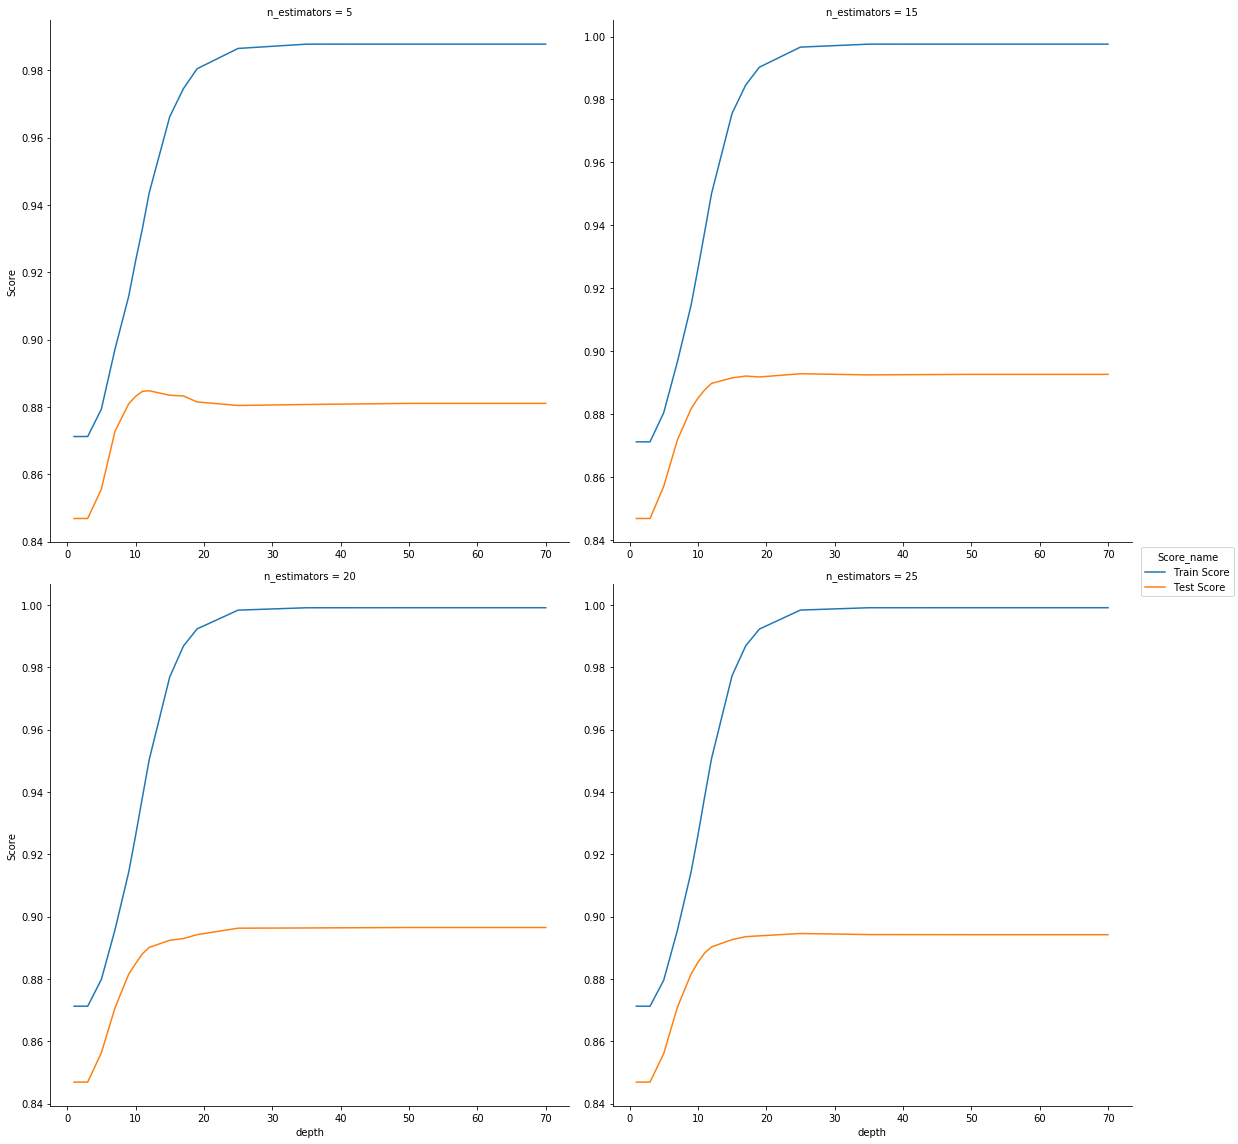

In [80]:
g = sns.FacetGrid(final_df, col="n_estimators",col_wrap=2, 
  hue="Score_name",sharex=False,sharey=False,size = 8).\
   map(plt.plot,'depth','Score').add_legend()

We can observe that for each no of estimators, if depth is increasing, model is overfitting. and for 20 estimators with depth in with depth >25.

In [85]:
#best scores
scores_df1.sort_values('Test_score',ascending=False).head(5)

,n_estimators,depth,Test_score,Test_std,Train_score
58,20,70,0.896479,0.007020,0.999095
54,20,50,0.896479,0.007020,0.999095
50,20,35,0.896336,0.007000,0.999079
46,20,25,0.896263,0.006714,0.998319
47,25,25,0.894559,0.006800,0.998347


for Avg Word2vec best score got at n_ectimators = 20 and depth = 25 with mean cv of 0.896263.

In [20]:
#testscore
list_of_sent_train=[]
for sent in train_df.final_text.values:
    list_of_sent_train.append(sent.split())
#avg word2vec for 
sent_vector_avgw2v_300 = avg_w2v(list_of_sent_train,w2v_model_300,300)
#stacking columns
train_avgw2v_300 = np.hstack((sent_vector_avgw2v_300,
            train_df[['HelpfulnessNumerator','HelpfulnessDenominator']]))
column = list(range(0,300))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator'])
train_df_avgw2v_300 = pd.DataFrame(train_avgw2v_300,columns=column)


list_of_sent_test=[]
for sent in test_df.final_text.values:
    list_of_sent_test.append(sent.split())
#avg word2vec for 
sent_vector_avgw2v_300_test = avg_w2v(list_of_sent_test,w2v_model_300,300)
#stacking columns
test_avgw2v_300 = np.hstack((sent_vector_avgw2v_300_test,
            test_df[['HelpfulnessNumerator','HelpfulnessDenominator']]))
column = list(range(0,300))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator'])
test_df_avgw2v_300 = pd.DataFrame(test_avgw2v_300,columns=column)


model = RF(n_estimators=20,max_depth=25)
model.fit(train_df_avgw2v_300,train_df.Score)
#Predicting training data
train_list = model.predict(train_df_avgw2v_300)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model.predict(test_df_avgw2v_300)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print("n_estimators=20,max_depth=25")
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

n_estimators=20,max_depth=25
Train Score 0.997889533971442
Test Score 0.8889438082946609
Test Precision 0.8970036119448542
Test Recall 0.9777092667346848
Test ConfusionMatrix [[ 8956 10123]
 [ 2010 88162]]


##### XGBoost

In [20]:
for i in range(0,100,10):
    model = xgb.XGBClassifier(n_estimators=i,n_jobs=-1)
    model.fit(X_train.drop('Score',axis=1),X_train.Score)
    #train score
    train_score = model.score(X_train.drop('Score',axis=1),X_train.Score)
    #test score
    test_score = model.score(X_test_cv.drop('Score',axis=1),X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 0 Train Score 0.1399878953621304 Test Score 0.17065484596474711
No of Estimators 10 Train Score 0.8844735603326533 Test Score 0.8588053768502537
No of Estimators 20 Train Score 0.8895563874380759 Test Score 0.8653302997018673
No of Estimators 30 Train Score 0.8968976261460178 Test Score 0.8743788901093154
No of Estimators 40 Train Score 0.9028658850956042 Test Score 0.8816883728228464
No of Estimators 50 Train Score 0.908088812176369 Test Score 0.8882263716721586
No of Estimators 60 Train Score 0.9120228194839838 Test Score 0.893365238767718
No of Estimators 70 Train Score 0.9152507229158727 Test Score 0.8973272660704011
No of Estimators 80 Train Score 0.9180919504158167 Test Score 0.9009623934306188
No of Estimators 90 Train Score 0.9202102620429938 Test Score 0.9035122129818505


In [26]:
for i in range(80,150,10):
    model = xgb.XGBClassifier(n_estimators=i,n_jobs=-1)
    model.fit(X_train.drop('Score',axis=1),X_train.Score)
    #train score
    train_score = model.score(X_train.drop('Score',axis=1),X_train.Score)
    #test score
    test_score = model.score(X_test_cv.drop('Score',axis=1),X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 80 Train Score 0.9180919504158167 Test Score 0.9009623934306188
No of Estimators 90 Train Score 0.9202102620429938 Test Score 0.9035122129818505
No of Estimators 100 Train Score 0.9221380377037054 Test Score 0.9060620325330823
No of Estimators 110 Train Score 0.9242731613279236 Test Score 0.908232648151054
No of Estimators 120 Train Score 0.9259655690300599 Test Score 0.9101548198127517
No of Estimators 130 Train Score 0.9277028087243057 Test Score 0.911710863538888
No of Estimators 140 Train Score 0.9288572325211271 Test Score 0.9135676552120927


In [27]:
for i in range(150,500,50):
    model = xgb.XGBClassifier(n_estimators=i,n_jobs=-1)
    model.fit(X_train.drop('Score',axis=1),X_train.Score)
    #train score
    train_score = model.score(X_train.drop('Score',axis=1),X_train.Score)
    #test score
    test_score = model.score(X_test_cv.drop('Score',axis=1),X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 150 Train Score 0.9302470242765237 Test Score 0.9147444950049689
No of Estimators 200 Train Score 0.9353466633789872 Test Score 0.9194910821695695
No of Estimators 250 Train Score 0.9391237587142185 Test Score 0.9230216015481981
No of Estimators 300 Train Score 0.9419089462240254 Test Score 0.9252183691615671
No of Estimators 350 Train Score 0.944593261751586 Test Score 0.9268659448715937
No of Estimators 400 Train Score 0.9466779493846809 Test Score 0.9281996966368534
No of Estimators 450 Train Score 0.9484712290690637 Test Score 0.929363460432031


We can obsever if no of estimators incresing then Test and Train scores also incresing.

In [32]:
from scipy.stats import uniform
eta1 = uniform.rvs(0,1,15,random_state=25)
print('with 150 estimators')
for i in eta1:
    model = xgb.XGBClassifier(learning_rate=i,n_estimators=150,n_jobs=-1)
    model.fit(X_train.drop('Score',axis=1),X_train.Score)
    #train score 
    train_score = model.score(X_train.drop('Score',axis=1),X_train.Score)
    #test score
    test_score = model.score(X_test_cv.drop('Score',axis=1),X_test_cv.Score)
    print('Learning Rate',i,'Train Score',train_score,'Test Score',test_score)

with 150 estimators
Learning Rate 0.8701241366272119 Train Score 0.9562944116921835 Test Score 0.9261467649981694
Learning Rate 0.5822769286725598 Train Score 0.9537950281320751 Test Score 0.9289842564987708
Learning Rate 0.27883894070106907 Train Score 0.9459214095178319 Test Score 0.9268005648831006
Learning Rate 0.18591123209017923 Train Score 0.9403286185021631 Test Score 0.9236754014331293
Learning Rate 0.4111001279251132 Train Score 0.9502420927573917 Test Score 0.930161096291647
Learning Rate 0.11737554713471554 Train Score 0.933211539754769 Test Score 0.917699670484858
Learning Rate 0.684968744374135 Train Score 0.9552576718746497 Test Score 0.9287750405355929
Learning Rate 0.4376110596596504 Train Score 0.9507688686646791 Test Score 0.9294811444113186
Learning Rate 0.5562293251719702 Train Score 0.9528871802918563 Test Score 0.930056488310058
Learning Rate 0.3670803216193239 Train Score 0.9490092129743786 Test Score 0.9290234844918668
Learning Rate 0.40236572881420285 Train Sc

In [18]:
#random search
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
np.random.seed(25)
param_distributions = {'max_depth':sp_randint(3,5),'learning_rate':uniform(0,1),
                       'n_estimators':sp_randint(50,700),'subsample':uniform(0.7,0.3)}
model_random_avgw2v_depth = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25),
                                       param_distributions=param_distributions,n_iter=30,
                                       cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_avgw2v_depth.fit(train_df_avgw2v_300.drop('Score',axis=1),train_df_avgw2v_300.Score)

In [23]:
dict_scores = []
idx = 0
for i in model_random_avgw2v_depth.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['learning_rate'])
    dict_score.append(i[0]['max_depth'])
    dict_score.append(i[0]['n_estimators'])
    dict_score.append(i[0]['subsample'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_avgw2v_depth.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['learning_rate','depth',
         'n_estimators','subsample','Test_score','Test_std','Train_score'])

In [25]:
scores_df.sort_values('Test_score',ascending=False)

,learning_rate,depth,n_estimators,subsample,Test_score,Test_std,Train_score
13,0.510903,4,576,0.927412,0.936679,0.003772,0.998045
2,0.437611,4,550,0.810124,0.936248,0.003834,0.996316
28,0.566830,3,693,0.937182,0.936002,0.004033,0.991577
4,0.406806,3,354,0.797815,0.935876,0.003101,0.975302
3,0.402366,3,309,0.859582,0.935630,0.003431,0.972967
6,0.481343,3,353,0.843264,0.935540,0.003151,0.977620
5,0.699186,4,612,0.950912,0.935052,0.005123,0.999616
16,0.076742,4,458,0.903955,0.934621,0.003908,0.966540
18,0.719055,4,672,0.818962,0.934254,0.004816,0.999800
10,0.456069,3,221,0.857746,0.933883,0.003535,0.968635


In [27]:
colm = list(scores_df.columns)
colm.remove('Test_std')

We can observe from above that learning rate between 0.4-0.6 giving good score and if we are incresing no of estimaters model efficiency is incresing.

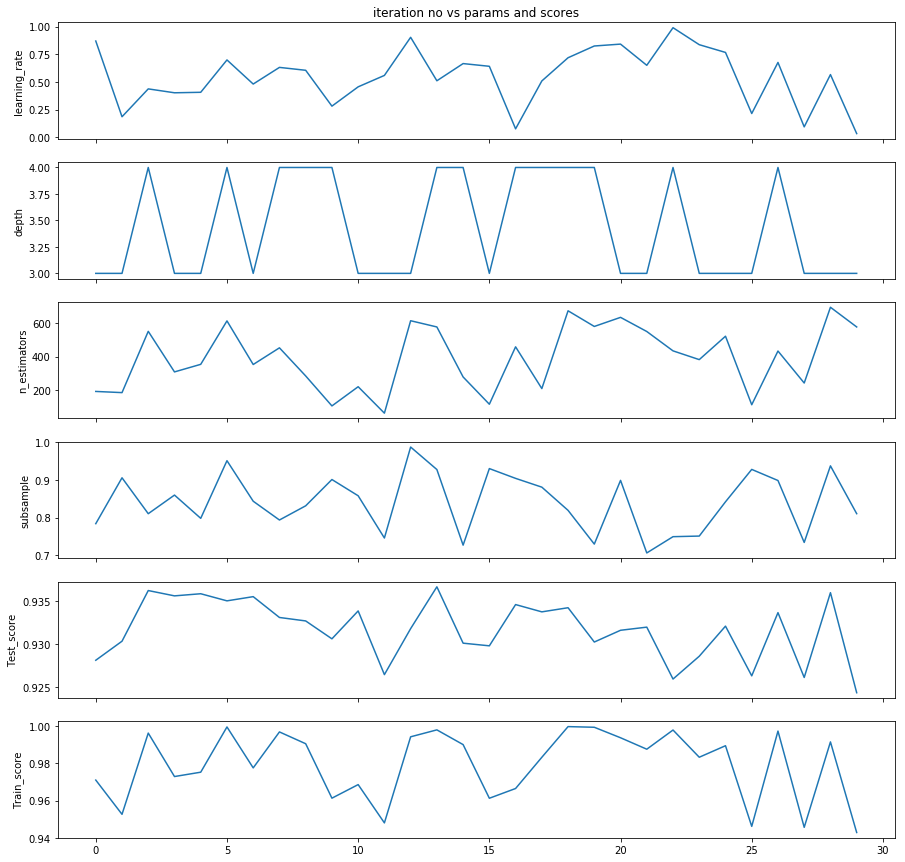

In [37]:
fig, axes = plt.subplots(6, 1,sharex=True,figsize=(15,15))
for ax,i in zip(axes.ravel(),colm):
    ax.plot(range(0,30),scores_df[i])
    ax.set_ylabel(i)
    if i == 'Train Score':
        ax.set_xlabel('Iteration no in random search')
    if i == 'learning_rate':
        ax.set_title('iteration no vs params and scores')

In [28]:
param_grid = {'max_depth':[5,7,9],
              'n_estimators':[560,800,900],
              'subsample':[0.8,0.93,1]}
model_grid_avgw2v = GridSearchCV(
                    xgb.XGBClassifier(n_jobs=-1,
                                    learning_rate=0.52,
                                    random_state=25),
                                    param_grid=param_grid,
                            cv=TimeSeriesSplit(n_splits=10),
                                        n_jobs=-1)
model_grid_avgw2v.fit(train_df_avgw2v_300.drop('Score',axis=1),
                                 train_df_avgw2v_300.Score)

In [30]:
dict_scores = []
idx = 0
for i in model_grid_avgw2v_depth.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['n_estimators'])
    dict_score.append(i[0]['max_depth'])
    dict_score.append(i[0]['subsample'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_grid_avgw2v_depth.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['n_estimators','depth',
         'subsample','Test_score','Test_std','Train_score'])

In [32]:
scores_df.sort_values('Test_score',ascending=False)

,n_estimators,depth,subsample,Test_score,Test_std,Train_score
7,900,5,0.93,0.939139,0.002537,1.000000
8,900,5,1.00,0.938992,0.002336,1.000000
4,800,5,0.93,0.938897,0.002644,1.000000
5,800,5,1.00,0.938690,0.002465,1.000000
13,800,7,0.93,0.938440,0.002398,1.000000
17,900,7,1.00,0.938435,0.002192,1.000000
16,900,7,0.93,0.938414,0.002297,1.000000
14,800,7,1.00,0.938289,0.002245,1.000000
12,800,7,0.80,0.937883,0.002347,1.000000
15,900,7,0.80,0.937823,0.002401,1.000000


Got best cv scores at no of estimators  = 900, depth = 5, learning rate = 0.52 and subsample = 0.93 with mean cv score of 0.939139.

In [13]:
#testscore
list_of_sent_train=[]
for sent in train_df.final_text.values:
    list_of_sent_train.append(sent.split())
#avg word2vec for 
sent_vector_avgw2v_300 = avg_w2v(list_of_sent_train,w2v_model_300,300)
#stacking columns
train_avgw2v_300 = np.hstack((sent_vector_avgw2v_300,
            train_df[['HelpfulnessNumerator','HelpfulnessDenominator']]))
column = list(range(0,300))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator'])
train_df_avgw2v_300 = pd.DataFrame(train_avgw2v_300,columns=column)


list_of_sent_test=[]
for sent in test_df.final_text.values:
    list_of_sent_test.append(sent.split())
#avg word2vec for 
sent_vector_avgw2v_300_test = avg_w2v(list_of_sent_test,w2v_model_300,300)
#stacking columns
test_avgw2v_300 = np.hstack((sent_vector_avgw2v_300_test,
            test_df[['HelpfulnessNumerator','HelpfulnessDenominator']]))
column = list(range(0,300))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator'])
test_df_avgw2v_300 = pd.DataFrame(test_avgw2v_300,columns=column)


model = xgb.XGBClassifier(max_depth=5,learning_rate=0.52,n_estimators=900,
                                 n_jobs=-1,subsample=0.93,random_state=25)
model.fit(train_df_avgw2v_300,train_df.Score)
#Predicting training data
train_list = model.predict(train_df_avgw2v_300)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model.predict(test_df_avgw2v_300)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print("""max_depth=5,learning_rate=0.52,n_estimators=900,subsample=0.93""")
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

max_depth=5,learning_rate=0.52,n_estimators=900,subsample=0.93
Train Score 1.0
Test Score 0.9303164273095899
Test Precision 0.9402160582696143
Test Recall 0.9777425364858271
Test ConfusionMatrix [[13473  5606]
 [ 2007 88165]]


### Tf-Idf Word2Vec

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class TfidfWeightedWord2Vec(BaseEstimator, TransformerMixin):
    '''
    Class for Tfidf Weighted Word2Vec Calculations
    '''
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = word2vec.vector_size
        self.tfidf = None

    def fit(self, X, y=None):
        tfidf = TfidfVectorizer()
        tfidf.fit(X[:,0])
        self.tfidf = tfidf
        #print(self.word2vec.wv.vocab.keys())
        return self
    
    def tf_idf_W2V(self,feature_names,tf_idf_trans_arr,list_of_sent):
        '''
        tfidf weighted word2vec calculation
        '''
        import operator
        dict_tfidf = {k: v for v, k in enumerate(feature_names)}
        sent_vectors = []
        i = 0
        for sent in list_of_sent: # for each review/sentence
            doc = [word for word in sent if word in self.word2vec.wv.vocab.keys()]
            if doc:
                #itemgetter
                f = operator.itemgetter(*doc)
                try:
                    #itemgetter from dict
                    final = f(dict_tfidf)
                    final = tf_idf_trans_arr[i,final]
                    #converting to dense
                    final = final.toarray()
                    #converting to diagnol matrix for multiplication
                    final= np.diag(final[0])
                    sent_vec = np.dot(final,np.array(self.word2vec.wv[doc]))
                    #tfidf weighted word to vec
                    sent_vec = np.sum(sent_vec,axis=0) / np.sum(final)
                except:
                    sent_vec = np.zeros(self.dim)             
            else:
                sent_vec = np.zeros(self.dim)
            sent_vectors.append(sent_vec)
            i = i+1
        return sent_vectors

    def transform(self, X):
        #transform data
        tf_idf_trans_arr = self.tfidf.transform(X[:,0])
        feature_names = self.tfidf.get_feature_names()
        list_of_sent = []
        for sent in X[:,0]:
            list_of_sent.append(sent.split())
        temp_vec = self.tf_idf_W2V(feature_names,tf_idf_trans_arr,list_of_sent)
        temp_vec= np.hstack((temp_vec,X[:,[1,2]]))
        return temp_vec

In [14]:
# For simple cv
#Train data
X_train = train_df.iloc[:round(train_df.shape[0]*0.70),:]
X_test_cv = train_df.iloc[round(train_df.shape[0]*0.70):,:]
#transforming to tfidf weighted word2vec
tfidfvect_w2v = TfidfWeightedWord2Vec(w2v_model_300)
tfidfvect_w2v.fit(X_train[['final_text','HelpfulnessNumerator',
                           'HelpfulnessDenominator']].values)
X_train_tfw2v = tfidfvect_w2v.transform(X_train[['final_text',
                'HelpfulnessNumerator','HelpfulnessDenominator']].values)
X_cv_tfw2v = tfidfvect_w2v.transform(X_test_cv[['final_text',
                 'HelpfulnessNumerator','HelpfulnessDenominator']].values)

##### Random Forest

In [14]:
#base model
model = RF(n_jobs=-1,random_state=25).fit(X_train_tfw2v,X_train.Score)
#train score
train_score = model.score(X_train_tfw2v,X_train.Score)
#test score
test_score = model.score(X_cv_tfw2v,X_test_cv.Score)
print('Train Score',train_score)
print('Test Score',test_score)

Train Score 0.9790018156956805
Test Score 0.8738950781944662


In [15]:
for i in range(1,100,5):
    model = RF(n_estimators=i,n_jobs=-1,random_state=25)
    model.fit(X_train_tfw2v,X_train.Score)
    #train score
    train_score = model.score(X_train_tfw2v,X_train.Score)
    #test score
    test_score = model.score(X_cv_tfw2v,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 1 Train Score 0.9284873685862232 Test Score 0.8177336680788744
No of Estimators 6 Train Score 0.974675528457107 Test Score 0.8645980438307442
No of Estimators 11 Train Score 0.977847391898859 Test Score 0.8718682985511794
No of Estimators 16 Train Score 0.9804756674362826 Test Score 0.8768633296720539
No of Estimators 21 Train Score 0.9805148954293784 Test Score 0.8747319420471782
No of Estimators 26 Train Score 0.981316267288337 Test Score 0.8770463936398347
No of Estimators 31 Train Score 0.9813554952814328 Test Score 0.8756603378837805
No of Estimators 36 Train Score 0.9816188832350765 Test Score 0.8775171295569852
No of Estimators 41 Train Score 0.9816188832350765 Test Score 0.8759349338354516
No of Estimators 46 Train Score 0.9817365672143642 Test Score 0.8774648255661907
No of Estimators 51 Train Score 0.9817421712133778 Test Score 0.8756864898791777
No of Estimators 56 Train Score 0.9817813992064738 Test Score 0.8770594696375333
No of Estimators 61 Train Score 0

In [16]:
#random search
param_distributions = {'randomforestclassifier__n_estimators':sp_randint(5,300)}
model_random_tfidfw2v = RandomizedSearchCV(make_pipeline(
                          TfidfWeightedWord2Vec(w2v_model_300),
                         RF(n_jobs=-1,random_state=25)),
                        param_distributions=param_distributions,n_iter=60,
                        cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_tfidfw2v.fit(train_df_tfw2v,train_df.Score)

In [44]:
dict_scores = []
idx = 0
for i in model_random_tfidfw2v.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['randomforestclassifier__n_estimators'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_tfidfw2v.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['n_estimators','Test_score',
                                               'Test_std','Train_score'])

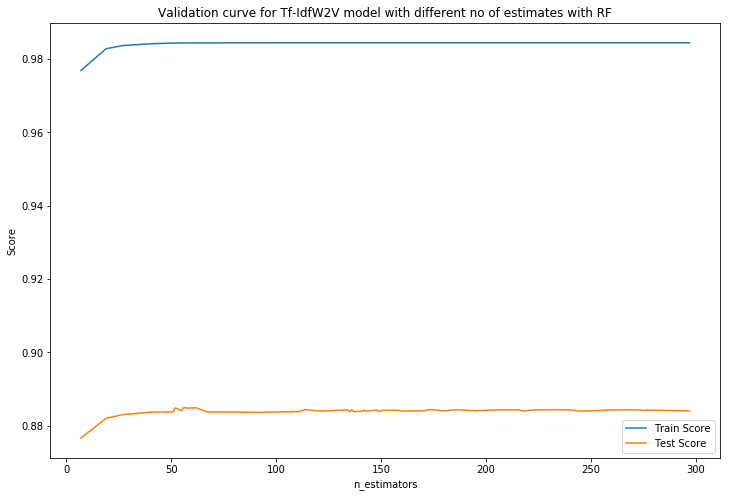

In [22]:
scores_df = scores_df.sort_values('n_estimators')
plt.figure(figsize=(12,8))
plt.plot(scores_df.n_estimators,scores_df.Train_score,label='Train Score')
plt.plot(scores_df.n_estimators,scores_df.Test_score,label='Test Score')
plt.title('Validation curve for Tf-IdfW2V model with different no of estimates with RF')
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.legend()

In [46]:
#best scores
scores_df.sort_values('Test_score',ascending=False).head(5)

,n_estimators,Test_score,Test_std,Train_score
46,56,0.884962,0.009991,0.984384
35,62,0.884918,0.010046,0.984405
15,52,0.884914,0.010177,0.984378
58,58,0.884841,0.010031,0.984390
18,114,0.884448,0.009929,0.984432


In [39]:
param_distributions = {
    'randomforestclassifier__n_estimators':sp_randint(10,70),
    'randomforestclassifier__max_depth':sp_randint(3,30),
    'randomforestclassifier__min_samples_split':sp_randint(2,8),
    'randomforestclassifier__class_weight':[None,'balanced']}
model_random_tfidfw2v = RandomizedSearchCV(make_pipeline(
                          TfidfWeightedWord2Vec(w2v_model_300),
                         RF(n_jobs=-1,random_state=25)),
                        param_distributions=param_distributions,n_iter=100,
                        cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_tfidfw2v.fit(train_df_tfw2v,train_df.Score)

In [47]:
dict_scores = []
idx = 0
for i in model_random_tfidfw2v_all.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['randomforestclassifier__n_estimators'])
    dict_score.append(i[0]['randomforestclassifier__max_depth'])
    dict_score.append(i[0]['randomforestclassifier__min_samples_split'])
    dict_score.append(i[0]['randomforestclassifier__class_weight'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_tfidfw2v_all.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['n_estimators','depth',
         'min_samples_split','class_weight','Test_score','Test_std','Train_score'])

In [49]:
scores_df.sort_values('Test_score',ascending=False).head(5)

,n_estimators,depth,min_samples_split,class_weight,Test_score,Test_std,Train_score
0,64,29,7,None,0.883093,0.010659,0.979521
55,49,28,6,None,0.882808,0.010204,0.980000
85,64,24,5,None,0.881937,0.010730,0.978783
71,61,24,3,None,0.881906,0.010798,0.980478
44,23,26,4,None,0.881863,0.010971,0.979109


We can observe that for no of estimators based on depth scores are changing and best score got at n_estimators at 56 and test  cv is 0.884962

In [50]:
#testscore
#transforming to tfidf weighted word2vec
tfidfvect_w2v = TfidfWeightedWord2Vec(w2v_model_300)
tfidfvect_w2v.fit(train_df[['final_text','HelpfulnessNumerator',
                           'HelpfulnessDenominator']].values)
X_train_tfw2v = tfidfvect_w2v.transform(train_df[['final_text',
                'HelpfulnessNumerator','HelpfulnessDenominator']].values)
X_cv_tfw2v = tfidfvect_w2v.transform(test_df[['final_text',
                 'HelpfulnessNumerator','HelpfulnessDenominator']].values)


model = RF(n_estimators=56)
model.fit(X_train_tfw2v,train_df.Score)
#Predicting training data
train_list = model.predict(X_train_tfw2v)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model.predict(X_cv_tfw2v)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('n_estimators',56)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

n_estimators 56
Train Score 0.9796524399811706
Test Score 0.8709485496700259
Test Precision 0.8726985900036254
Test Recall 0.9877234618285056
Test ConfusionMatrix [[ 6087 12992]
 [ 1107 89065]]


##### Xg Boost

In [15]:
X_train_tfw2v = X_train_tfw2v.astype(float)
X_cv_tfw2v = X_cv_tfw2v.astype(float)

In [64]:
for i in range(0,100,10):
    model = xgb.XGBClassifier(n_estimators=i,n_jobs=-1)
    model.fit(X_train_tfw2v,X_train.Score)
    #train score
    train_score = model.score(X_train_tfw2v,X_train.Score)
    #test score
    test_score = model.score(X_cv_tfw2v,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 0 Train Score 0.1399878953621304 Test Score 0.17065484596474711
No of Estimators 10 Train Score 0.8740277061711237 Test Score 0.84591244311941
No of Estimators 20 Train Score 0.8791217412745735 Test Score 0.8521627700193525
No of Estimators 30 Train Score 0.8847537602833382 Test Score 0.8581908049584184
No of Estimators 40 Train Score 0.8902961153078837 Test Score 0.8641142319158952
No of Estimators 50 Train Score 0.8953509224182377 Test Score 0.8695930749516189
No of Estimators 60 Train Score 0.8985956378471678 Test Score 0.8736989382289869
No of Estimators 70 Train Score 0.901431261348098 Test Score 0.8769810136513416
No of Estimators 80 Train Score 0.9036168209634395 Test Score 0.879818505151943
No of Estimators 90 Train Score 0.9063739884781781 Test Score 0.8818452847952298


In [23]:
for i in range(100,500,50):
    model = xgb.XGBClassifier(n_estimators=i,n_jobs=-1)
    model.fit(X_train_tfw2v,X_train.Score)
    #train score
    train_score = model.score(X_train_tfw2v,X_train.Score)
    #test score
    test_score = model.score(X_cv_tfw2v,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)  

No of Estimators 100 Train Score 0.907831028221739 Test Score 0.883754380459229
No of Estimators 150 Train Score 0.9155925668557082 Test Score 0.8910115591819656
No of Estimators 200 Train Score 0.9202550940351034 Test Score 0.8957450703488676
No of Estimators 250 Train Score 0.9233316894936227 Test Score 0.8984779538678801
No of Estimators 300 Train Score 0.9258422810517586 Test Score 0.9008708614467283
No of Estimators 350 Train Score 0.9279942166730178 Test Score 0.902453057168262
No of Estimators 400 Train Score 0.929669812378113 Test Score 0.903878340917412
No of Estimators 450 Train Score 0.9312501400999753 Test Score 0.9051728646895758


In [25]:
for i in range(500,1000,50):
    model = xgb.XGBClassifier(n_estimators=i,n_jobs=-1)
    model.fit(X_train_tfw2v,X_train.Score)
    #train score
    train_score = model.score(X_train_tfw2v,X_train.Score)
    #test score
    test_score = model.score(X_cv_tfw2v,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)  

No of Estimators 500 Train Score 0.9327239918405774 Test Score 0.9060881845284795
No of Estimators 550 Train Score 0.9341361995920289 Test Score 0.9069381243788901
No of Estimators 600 Train Score 0.9353410593799736 Test Score 0.9075396202730268
No of Estimators 650 Train Score 0.9363497792024389 Test Score 0.9080757361786704
No of Estimators 700 Train Score 0.9373584990249042 Test Score 0.9088733720382866
No of Estimators 750 Train Score 0.9381262468897805 Test Score 0.9091871959830535
No of Estimators 800 Train Score 0.9390284907309856 Test Score 0.9096840838956012
No of Estimators 850 Train Score 0.9398915065790948 Test Score 0.9101286678173545
No of Estimators 900 Train Score 0.940939454394656 Test Score 0.9106647837229981
No of Estimators 950 Train Score 0.9417856582457241 Test Score 0.9108216956953815


With increase in no of estimatores test score is incresing.

In [26]:
for i in range(500,1000,50):
    model = xgb.XGBClassifier(n_estimators=i,learning_rate=0.5,n_jobs=-1)
    model.fit(X_train_tfw2v,X_train.Score)
    #train score
    train_score = model.score(X_train_tfw2v,X_train.Score)
    #test score
    test_score = model.score(X_cv_tfw2v,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)  

No of Estimators 500 Train Score 0.9558012597789782 Test Score 0.9105732517391077
No of Estimators 550 Train Score 0.9579980273923472 Test Score 0.9108478476907788
No of Estimators 600 Train Score 0.9597016430925108 Test Score 0.9108478476907788
No of Estimators 650 Train Score 0.9616406267512497 Test Score 0.9110962916470526
No of Estimators 700 Train Score 0.9634283024366188 Test Score 0.9117762435273812
No of Estimators 750 Train Score 0.964918966174262 Test Score 0.9113447356033265
No of Estimators 800 Train Score 0.9664096299119052 Test Score 0.9115277995711073
No of Estimators 850 Train Score 0.9679171056465894 Test Score 0.9115408755688059
No of Estimators 900 Train Score 0.9692116294187533 Test Score 0.9122862074376274
No of Estimators 950 Train Score 0.9705397771849992 Test Score 0.9121031434698468


In [27]:
for i in [700,900,950]:
    model = xgb.XGBClassifier(n_estimators=i,learning_rate=0.5,
                    n_jobs=-1,reg_alpha=0.2, reg_lambda=0.7)
    model.fit(X_train_tfw2v,X_train.Score)
    #train score
    train_score = model.score(X_train_tfw2v,X_train.Score)
    #test score
    test_score = model.score(X_cv_tfw2v,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)  

No of Estimators 700 Train Score 0.9641400103113582 Test Score 0.9118023955227784
No of Estimators 900 Train Score 0.9698560893053283 Test Score 0.912652335373189
No of Estimators 950 Train Score 0.9709376611149716 Test Score 0.9128877033317642


In [18]:
for i in [700,900,950]:
    model = xgb.XGBClassifier(n_estimators=i,learning_rate=0.5,
            max_depth=6,n_jobs=-1,reg_alpha=0.2, reg_lambda=0.7)
    model.fit(X_train_tfw2v,X_train.Score)
    #train score
    train_score = model.score(X_train_tfw2v,X_train.Score)
    #test score
    test_score = model.score(X_cv_tfw2v,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)  

No of Estimators 700 Train Score 0.9815628432449396 Test Score 0.9140383911292431
No of Estimators 900 Train Score 0.9816581112281724 Test Score 0.9146137350279826
No of Estimators 950 Train Score 0.9816973392212683 Test Score 0.9145222030440923


We can observe from initial simple cv that incresing the estimators are incresing test scores and there is impact of test scores with regularization and learning rate is also incresing the test score

In [16]:
from xgboost import XGBClassifier
param_distributions = {'xgbclassifier__n_estimators':sp_randint(600,1000),
                       'xgbclassifier__max_depth':sp_randint(3,10),
                       'xgbclassifier__learning_rate':uniform(0,1),
                       'xgbclassifier__subsample':uniform(0,1),
                       'xgbclassifier__reg_alpha':uniform(0,1),
                       'xgbclassifier__reg_lambda':uniform(0,1),
                      'xgbclassifier__colsample_bylevel':uniform(0.7,0.3)}
model_random_tfidfw2v_xgb = RandomizedSearchCV(make_pipeline(
                          TfidfWeightedWord2Vec(w2v_model_300),
                            XGBClassifier(n_jobs=-1,random_state=25)),
                        param_distributions=param_distributions,n_iter=30,
                        cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_tfidfw2v_xgb.fit(train_df_tfw2v,train_df.Score)

In [19]:
dict_scores = []
idx = 0
for i in model_random_tfidfw2v_xgb.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['xgbclassifier__n_estimators'])
    dict_score.append(i[0]['xgbclassifier__max_depth'])
    dict_score.append(i[0]['xgbclassifier__subsample'])
    dict_score.append(i[0]['xgbclassifier__colsample_bylevel'])
    dict_score.append(i[0]['xgbclassifier__learning_rate'])
    dict_score.append(i[0]['xgbclassifier__reg_alpha'])
    dict_score.append(i[0]['xgbclassifier__reg_lambda'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_tfidfw2v_xgb.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['n_estimators','depth',
         'subsample','colsample_bylevel','learning_rate','reg_alpha',
              'reg_lambda','Test_score','Test_std','Train_score'])

In [22]:
scores_df.sort_values('Test_score',ascending=False).head()

,n_estimators,depth,subsample,colsample_bylevel,learning_rate,reg_alpha,reg_lambda,Test_score,Test_std,Train_score
20,884,4,0.994481,0.791814,0.229976,0.998268,0.150014,0.920558,0.006677,0.978847
6,906,5,0.524254,0.885013,0.151921,0.644862,0.309258,0.920411,0.006462,0.982022
3,903,7,0.849676,0.776976,0.231515,0.477546,0.631773,0.919302,0.005702,0.984339
21,667,3,0.960319,0.737489,0.351055,0.323604,0.806417,0.919064,0.006489,0.967847
19,894,3,0.328739,0.822887,0.109562,0.973815,0.752860,0.918870,0.007118,0.953416


from random search got good score at n_estimators = 884, depth = 4, subsample =	0.994481, colsample_bylevel=0.791814, learning_rate = 0.229976, reg_alpha = 0.998268, reg_lambda = 0.150014 and Test_score  is 0.920558

In [24]:
#testscore
#transforming to tfidf weighted word2vec
tfidfvect_w2v = TfidfWeightedWord2Vec(w2v_model_300)
tfidfvect_w2v.fit(train_df[['final_text','HelpfulnessNumerator',
                           'HelpfulnessDenominator']].values)
X_train_tfw2v = tfidfvect_w2v.transform(train_df[['final_text',
                'HelpfulnessNumerator','HelpfulnessDenominator']].values)
X_cv_tfw2v = tfidfvect_w2v.transform(test_df[['final_text',
                 'HelpfulnessNumerator','HelpfulnessDenominator']].values)


model  = xgb.XGBClassifier(n_estimators=884,max_depth=4,
                           subsample=0.994481,
                           colsample_bylevel=0.791814,
                           learning_rate=0.229976,reg_alpha=0.998268,
                           reg_lambda = 0.150014)
model.fit(X_train_tfw2v,train_df.Score)
#Predicting training data
train_list = model.predict(X_train_tfw2v)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model.predict(X_cv_tfw2v)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('Depth',9)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

Depth 9
Train Score 0.9620547622783618
Test Score 0.9055477753064045
Test Precision 0.9101124749627652
Test Recall 0.9826110100696447
Test ConfusionMatrix [[10328  8751]
 [ 1568 88604]]


#### Bag of Words:

In [17]:
#BoW with cleaned data and without stopwords
#simple cv for train data
scores_train = []
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.remove('not')
stop.remove('very')
#CountVectorizer for BoW
count_vect = CountVectorizer(stop_words=list(stop),dtype=np.int8)
X_train = train_df.iloc[:round(train_df.shape[0]*0.70),:]
X_test_cv = train_df.iloc[round(train_df.shape[0]*0.70):,:]
final_counts_train = count_vect.fit_transform(
        X_train['final_text'].values)
#test
X_test = count_vect.transform(X_test_cv['final_text'].values)

##### Random Forest:

In [16]:
#base model
model = RF(n_jobs=-1,random_state=25).fit(final_counts_train,X_train.Score)
#train score
train_score = model.score(final_counts_train,X_train.Score)
#test score
test_score = model.score(X_test,X_test_cv.Score)
print('Train Score',train_score)
print('Test Score',test_score)

Train Score 0.9972204164892067
Test Score 0.8877294837596108


In [17]:
for i in range(1,20):
    model = RF(n_estimators=i,n_jobs=-1,random_state=25)
    model.fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score) 

No of Estimators 1 Train Score 0.9418921342269844 Test Score 0.8236440190386527
No of Estimators 2 Train Score 0.9373136670327946 Test Score 0.7947199121292955
No of Estimators 3 Train Score 0.9773766559817085 Test Score 0.8608452324912391
No of Estimators 4 Train Score 0.9852726905920065 Test Score 0.8612505884198964
No of Estimators 5 Train Score 0.9875198941964987 Test Score 0.8727574663946859
No of Estimators 6 Train Score 0.9932191611934277 Test Score 0.8796877451749568
No of Estimators 7 Train Score 0.9916948734617023 Test Score 0.8778963334902453
No of Estimators 8 Train Score 0.9960323686983031 Test Score 0.8851404362152833
No of Estimators 9 Train Score 0.9943567729932079 Test Score 0.8803938490506825
No of Estimators 10 Train Score 0.9972204164892067 Test Score 0.8877294837596108
No of Estimators 11 Train Score 0.9958138127367689 Test Score 0.8814399288665725
No of Estimators 12 Train Score 0.9980498083432338 Test Score 0.8878863957319943
No of Estimators 13 Train Score 0.996

In [19]:
print('with 14 estimators')
for i in [5,8,10,20,25,30,50,100,200,300,400]:
    model = RF(n_estimators=14,max_depth=i,n_jobs=-1,random_state=25)
    model.fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('Depth',i,'Train Score',train_score,'Test Score',test_score) 

with 14 estimators
Depth 5 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Depth 8 Train Score 0.8600233126358969 Test Score 0.8293451540352529
Depth 10 Train Score 0.8600569366299792 Test Score 0.8293713060306501
Depth 20 Train Score 0.8624890722019233 Test Score 0.8304958418327318
Depth 25 Train Score 0.8648819797807715 Test Score 0.8318034416025942
Depth 30 Train Score 0.8687487391002219 Test Score 0.8338956012343742
Depth 50 Train Score 0.8927954988679923 Test Score 0.843127255609603
Depth 100 Train Score 0.9512171885857749 Test Score 0.8656310476489356
Depth 200 Train Score 0.9900136737575934 Test Score 0.8815183848527642
Depth 300 Train Score 0.9969794445316178 Test Score 0.8877556357550082
Depth 400 Train Score 0.9983019882988501 Test Score 0.8896778074167059


In [20]:
print('with 14 estimators')
for i in [400,500,600,700,800]:
    model = RF(n_estimators=14,max_depth=i,n_jobs=-1,random_state=25)
    model.fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('Depth',i,'Train Score',train_score,'Test Score',test_score) 

with 14 estimators
Depth 400 Train Score 0.9983019882988501 Test Score 0.8896778074167059
Depth 500 Train Score 0.9983356122929322 Test Score 0.887794863748104
Depth 600 Train Score 0.9983692362870145 Test Score 0.8885794236100214
Depth 700 Train Score 0.9983972562820829 Test Score 0.8874287358125424
Depth 800 Train Score 0.9983972562820829 Test Score 0.8874287358125424


We can observe that with increase in no of estimators score is incresing and with high variance base models score is increasing.

In [14]:
param_distributions = {'randomforestclassifier__n_estimators':sp_randint(10,100),
                       'randomforestclassifier__max_depth':sp_randint(50,600)}
model_random_bow = RandomizedSearchCV(make_pipeline(
                        CountVectorizer(stop_words=list(stop),dtype=np.int8),
                        RF(n_jobs=-1,random_state=25)),
                        param_distributions=param_distributions,
                        n_iter=50,
                        cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_bow.fit(train_df['final_text'],train_df.Score)

In [18]:
dict_scores = []
idx = 0
for i in model_random_bow.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['randomforestclassifier__n_estimators'])
    dict_score.append(i[0]['randomforestclassifier__max_depth'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_bow.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['n_estimators','depth',
                                'Test_score','Test_std','Train_score'])

In [20]:
scores_df.sort_values('Test_score',ascending=False).head(10)

,n_estimators,depth,Test_score,Test_std,Train_score
17,28,483,0.891749,0.007396,0.999524
49,26,434,0.891680,0.007370,0.999376
45,28,389,0.891253,0.007705,0.999268
37,34,479,0.891046,0.007578,0.999683
18,40,404,0.890343,0.007515,0.999657
12,26,251,0.890006,0.008157,0.996093
35,54,564,0.889657,0.008277,0.999923
13,60,542,0.889411,0.008074,0.999951
41,66,567,0.889324,0.008297,0.999961
15,20,210,0.889212,0.008916,0.992222


Best cv score got at no of estimators = 28, depth = 483 and Test cv score is 0.891749

In [18]:
#Test scores
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.remove('not')
stop.remove('very')
#CountVectorizer for BoW
count_vect = CountVectorizer(stop_words=list(stop),dtype=np.int8)
final_counts_train = count_vect.fit_transform(
        train_df['final_text'].values)
#test
X_test = count_vect.transform(test_df['final_text'].values)

model = RF(n_estimators=28,max_depth=483)
model.fit(final_counts_train,train_df.Score)
#Predicting training data
train_list = model.predict(final_counts_train)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print("n_estimators=28,max_depth=483")
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

n_estimators=28,max_depth=483
Train Score 0.9995606464773262
Test Score 0.8887058242029822
Test Precision 0.8856493153393643
Test Recall 0.9934236791908797
Test ConfusionMatrix [[ 7513 11566]
 [  593 89579]]


In [25]:
import operator
importances = model.feature_importances_
features = count_vect.get_feature_names()
dict_feature = dict(zip(features,importances))
sorted_feature = dict(sorted(dict_feature.items(), key=operator.itemgetter(1),reverse=True))

In [29]:
#To 100 features to seperate the data using Bag of words with RF
list_feature = list(sorted_feature.keys())[0:100]
list_fval = list(sorted_feature.values())[0:100]
print(list_feature)

['not', 'great', 'disappointed', 'terrible', 'love', 'wa', 'horrible', 'best', 'awful', 'worst', 'money', 'good', 'disappointing', 'delicious', 'bad', 'waste', 'taste', 'return', 'disgusting', 'yuck', 'like', 'would', 'disappointment', 'stale', 'product', 'excellent', 'poor', 'perfect', 'thought', 'beware', 'threw', 'very', 'flavor', 'received', 'didnt', 'one', 'favorite', 'dont', 'gross', 'unfortunately', 'buy', 'refund', 'wonderful', 'nasty', 'find', 'price', 'box', 'nothing', 'ha', 'misleading', 'china', 'nice', 'description', 'easy', 'weak', 'amazon', 'bland', 'get', 'make', 'maybe', 'much', 'tasteless', 'overpriced', 'even', 'really', 'tasted', 'coffee', 'ordered', 'store', 'item', 'review', 'time', 'tasty', 'wont', 'opened', 'bought', 'little', 'better', 'away', 'worse', 'use', 'food', 'yummy', 'tea', 'sorry', 'tried', 'well', 'mistake', 'highly', 'sweet', 'smell', 'rip', 'ingredient', 'day', 'bag', 'got', 'way', 'order', 'trash', 'ive']


([<matplotlib.axis.XTick at 0x153cdb9907b8>,
 <a list of 50 Text xticklabel objects>)

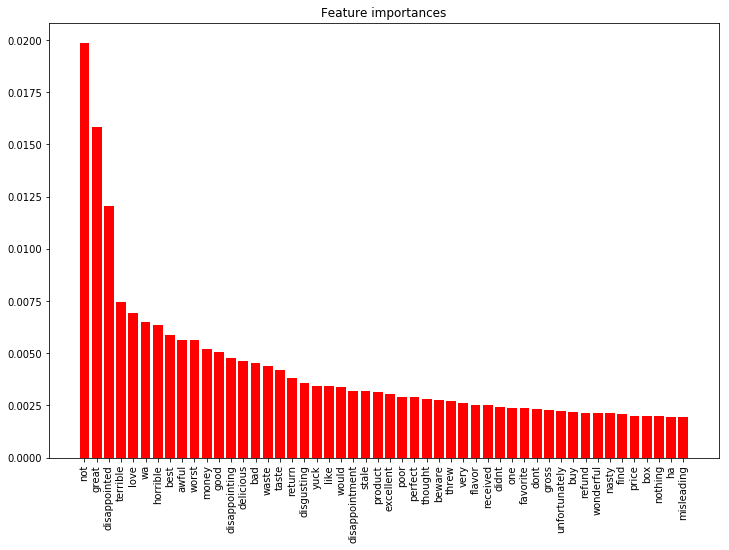

In [35]:
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(len(list_feature[0:50])),list_fval[0:50],
       color="r")
plt.xticks(range(len(list_feature[0:50])), 
           list_feature[0:50],rotation = 90)

##### XGBoost

In [24]:
#base model
model = xgb.XGBClassifier(n_jobs=-1,random_state=25).fit(final_counts_train,X_train.Score)
#train score
train_score = model.score(final_counts_train,X_train.Score)
#test score
test_score = model.score(X_test,X_test_cv.Score)
print('Train Score',train_score)
print('Test Score',test_score)

Train Score 0.8965894062002645
Test Score 0.8765233537318897


In [29]:
for i in range(0,100,10):
    model = xgb.XGBClassifier(n_estimators=i,n_jobs=-1)
    model = model.fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 0 Train Score 0.1399878953621304 Test Score 0.17065484596474711
No of Estimators 10 Train Score 0.8616652843469099 Test Score 0.8314765416601286
No of Estimators 20 Train Score 0.8644224518616485 Test Score 0.8354516449605105
No of Estimators 30 Train Score 0.8701217188585775 Test Score 0.8432057115957947
No of Estimators 40 Train Score 0.8749467620093699 Test Score 0.8494168105026414
No of Estimators 50 Train Score 0.8794747932124364 Test Score 0.8547387415659815
No of Estimators 60 Train Score 0.8832911165407635 Test Score 0.8592368847743083
No of Estimators 70 Train Score 0.8868832799085428 Test Score 0.8644934358491553
No of Estimators 80 Train Score 0.8911759431530341 Test Score 0.8697107589309064
No of Estimators 90 Train Score 0.8940451906480464 Test Score 0.8735289502589048


In [28]:
for i in range(50,500,50):
    model = xgb.XGBClassifier(n_estimators=i,n_jobs=-1)
    model = model.fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 50 Train Score 0.8794747932124364 Test Score 0.8547387415659815
No of Estimators 100 Train Score 0.8965894062002645 Test Score 0.8765233537318897
No of Estimators 150 Train Score 0.9057799645827262 Test Score 0.8880040797112819
No of Estimators 200 Train Score 0.9116809755441483 Test Score 0.895731994351169
No of Estimators 250 Train Score 0.9159904507856806 Test Score 0.901093153407605
No of Estimators 300 Train Score 0.919470534173186 Test Score 0.9047936607563157
No of Estimators 350 Train Score 0.9223005536751026 Test Score 0.9079057482085883
No of Estimators 400 Train Score 0.9249064132164713 Test Score 0.9105732517391077
No of Estimators 450 Train Score 0.9269294568604156 Test Score 0.9127307913593807


In [30]:
for i in range(500,1050,50):
    model = xgb.XGBClassifier(n_estimators=i,n_jobs=-1)
    model = model.fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 500 Train Score 0.9287059245477572 Test Score 0.9151498509336262
No of Estimators 550 Train Score 0.9303422922597565 Test Score 0.9166405146712694
No of Estimators 600 Train Score 0.9319058079845778 Test Score 0.9184319263559809
No of Estimators 650 Train Score 0.9331554997646321 Test Score 0.9198179821120351
No of Estimators 700 Train Score 0.9345172715249602 Test Score 0.920694073957843
No of Estimators 750 Train Score 0.9355820313375625 Test Score 0.9219493697369109
No of Estimators 800 Train Score 0.9368653471116989 Test Score 0.9226947016057325
No of Estimators 850 Train Score 0.93791329492726 Test Score 0.9238715413986087
No of Estimators 900 Train Score 0.9388883907556432 Test Score 0.9246822532559235
No of Estimators 950 Train Score 0.9397458026047387 Test Score 0.9253752811339505
No of Estimators 1000 Train Score 0.9407601264262178 Test Score 0.9262382969820597


In [31]:
for i in [1200,1500,1750,2100]:
    model = xgb.XGBClassifier(n_estimators=i,n_jobs=-1)
    model = model.fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 1200 Train Score 0.9435397099370111 Test Score 0.9283043046184424
No of Estimators 1500 Train Score 0.9471150613077493 Test Score 0.9314817720592081
No of Estimators 1750 Train Score 0.9496424648629261 Test Score 0.9326455358543857
No of Estimators 2100 Train Score 0.9527190603214454 Test Score 0.9345284795229876


even increase in estimators, test score alo increasing

In [12]:
param_distributions = {'xgbclassifier__n_estimators':sp_randint(600,2000),
                       'xgbclassifier__max_depth':sp_randint(3,9),
                       'xgbclassifier__learning_rate':uniform(0,1),
                       'xgbclassifier__subsample':uniform(0,1),
                       'xgbclassifier__reg_alpha':uniform(0,1),
                       'xgbclassifier__reg_lambda':uniform(0,1),
                      'xgbclassifier__colsample_bylevel':uniform(0.7,0.3)}

model_random_bow = RandomizedSearchCV(make_pipeline(CountVectorizer(stop_words=list(stop),dtype=np.int8),
                                                    XGBClassifier(n_jobs=-1,random_state=25)),
                                       param_distributions=param_distributions,n_iter=25,
                                       cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_bow.fit(train_df['final_text'],train_df.Score)
pickle.dump(model_random_bow,open('model_random_bow_xgb.p','wb'))

In [16]:
dict_scores = []
idx = 0
for i in model_random_bow_xgb.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['xgbclassifier__n_estimators'])
    dict_score.append(i[0]['xgbclassifier__max_depth'])
    dict_score.append(i[0]['xgbclassifier__subsample'])
    dict_score.append(i[0]['xgbclassifier__colsample_bylevel'])
    dict_score.append(i[0]['xgbclassifier__learning_rate'])
    dict_score.append(i[0]['xgbclassifier__reg_alpha'])
    dict_score.append(i[0]['xgbclassifier__reg_lambda'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_bow_xgb.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['n_estimators','depth',
         'subsample','colsample_bylevel','learning_rate','reg_alpha',
              'reg_lambda','Test_score','Test_std','Train_score'])

In [17]:
scores_df.sort_values('Test_score',ascending=False)

,n_estimators,depth,subsample,colsample_bylevel,learning_rate,reg_alpha,reg_lambda,Test_score,Test_std,Train_score
2,1825,3,0.836375,0.859582,0.406806,0.699186,0.366395,0.938228,0.003046,0.981074
12,1240,3,0.660874,0.761028,0.259216,0.676561,0.021376,0.937136,0.002877,0.968227
16,1763,6,0.320007,0.952691,0.177006,0.958540,0.762318,0.933874,0.004498,0.986529
7,1114,6,0.750906,0.990907,0.666196,0.577135,0.121505,0.931410,0.003405,0.998340
23,1119,3,0.198074,0.713333,0.293012,0.588749,0.987940,0.930107,0.004097,0.956563
13,830,5,0.790607,0.728332,0.831163,0.566830,0.174626,0.929563,0.002793,0.993391
5,614,5,0.471378,0.857746,0.559242,0.151921,0.903585,0.929356,0.003601,0.980291
9,1615,8,0.662077,0.947542,0.712552,0.210908,0.844187,0.928485,0.003783,0.999967
10,655,4,0.725973,0.895196,0.857754,0.990475,0.137572,0.928446,0.003519,0.983068
4,1681,8,0.289804,0.831081,0.281701,0.669612,0.456069,0.928329,0.003828,0.996344


From above df we can observe that second row in the df i.e 12th index with 1240 estimators is giving max similar scores as 1825 estimators so for better time complexity n estimators coosen as 1240. and got good score at n_estimators = 1240, depth = 3, subsample = 0.660874, colsample_bylevel=0.761028, learning_rate = 0.259216, reg_alpha = 0.676561, reg_lambda = 0.021376 and Test_score is 0.937136

In [19]:
param_distributions1 = {'xgbclassifier__n_estimators':sp_randint(600,2000),
                       'xgbclassifier__max_depth':sp_randint(3,9)}

model_random_bow1 = RandomizedSearchCV(make_pipeline(CountVectorizer(stop_words=list(stop),dtype=np.int8),
                                                    XGBClassifier(n_jobs=-1,random_state=25)),
                                       param_distributions=param_distributions1,n_iter=20,
                                       cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_bow1.fit(train_df['final_text'],train_df.Score)
pickle.dump(model_random_bow1,open('model_random_bow_xgb1.p','wb'))

In [21]:
dict_scores = []
idx = 0
for i in model_random_bow1.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['xgbclassifier__n_estimators'])
    dict_score.append(i[0]['xgbclassifier__max_depth'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_bow1.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df1 = pd.DataFrame(dict_scores,columns=['n_estimators','depth',
                'Test_score','Test_std','Train_score'])

In [22]:
scores_df1.sort_values('Test_score',ascending=False)

,n_estimators,depth,Test_score,Test_std,Train_score
18,1978,7,0.938181,0.003358,0.987153
5,1877,7,0.938030,0.003206,0.986398
2,1486,8,0.937512,0.003099,0.986929
19,1472,8,0.937508,0.003046,0.986764
8,1712,6,0.937482,0.002863,0.980572
3,1365,7,0.936951,0.002875,0.981748
9,1452,6,0.936852,0.002762,0.977774
15,1249,7,0.936610,0.003017,0.980420
14,1581,5,0.936002,0.002954,0.972947
6,1053,7,0.935682,0.003258,0.977682


above model is better than this best model with estimators 1978, depth 7, because it is generalizing train and test data's well

In [36]:
#Test scores
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.remove('not')
stop.remove('very')
#CountVectorizer for BoW
count_vect = CountVectorizer(stop_words=list(stop),dtype=np.int8)
final_counts_train = count_vect.fit_transform(
        train_df['final_text'].values)
#test
X_test = count_vect.transform(test_df['final_text'].values)
model = xgb.XGBClassifier(max_depth=3,learning_rate=0.259216,
                             n_estimators=1240,n_jobs=-1,
                            subsample=0.660874,colsample_bylevel=0.761028,
                            reg_alpha=0.676561,reg_lambda=0.021376)
model.fit(final_counts_train,train_df.Score)
#Predicting training data
train_list = model.predict(final_counts_train)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('''max_depth=3,learning_rate=0.259216,n_estimators=1240,n_jobs=-1,
subsample=0.660874,colsample_bylevel=0.761028,reg_alpha=0.676561,
reg_lambda=0.021376''')
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

max_depth=3,learning_rate=0.259216,n_estimators=1240,n_jobs=-1,
subsample=0.660874,colsample_bylevel=0.761028,reg_alpha=0.676561,
reg_lambda=0.021376
Train Score 0.956825670798682
Test Score 0.9375749421057931
Test Precision 0.949588987896179
Test Recall 0.9761899480991882
Test ConfusionMatrix [[14406  4673]
 [ 2147 88025]]


In [37]:
import operator
importances = model.feature_importances_
features = count_vect.get_feature_names()
dict_feature = dict(zip(features,importances))
sorted_feature = dict(sorted(dict_feature.items(), 
                    key=operator.itemgetter(1),reverse=True))

In [38]:
#To 100 features to seperate the data using Bag of words with RF
list_feature = list(sorted_feature.keys())[0:100]
list_fval = list(sorted_feature.values())[0:100]
print(list_feature)

['not', 'wa', 'like', 'great', 'good', 'product', 'taste', 'love', 'one', 'best', 'flavor', 'would', 'food', 'ha', 'get', 'very', 'amazon', 'really', 'dont', 'price', 'day', 'however', 'make', 'use', 'much', 'better', 'buy', 'didnt', 'little', 'try', 'time', 'bad', 'delicious', 'even', 'store', 'also', 'coffee', 'could', 'star', 'find', 'bit', 'box', 'something', 'sugar', 'well', 'found', 'review', 'still', 'used', 'tried', 'year', 'bag', 'bought', 'cat', 'chocolate', 'disappointed', 'first', 'ive', 'perfect', 'though', 'wont', 'brand', 'excellent', 'shipping', 'sweet', 'tea', 'thought', 'water', 'ingredient', 'know', 'nice', 'pretty', 'terrible', 'come', 'disappointing', 'doesnt', 'drink', 'dry', 'favorite', 'looking', 'money', 'old', 'ordered', 'say', 'small', 'stick', 'thing', 'unfortunately', 'way', 'work', 'amazing', 'back', 'changed', 'doe', 'high', 'keep', 'long', 'quite', 'smell', 'tasty']


([<matplotlib.axis.XTick at 0x153cda7d6780>,
 <a list of 50 Text xticklabel objects>)

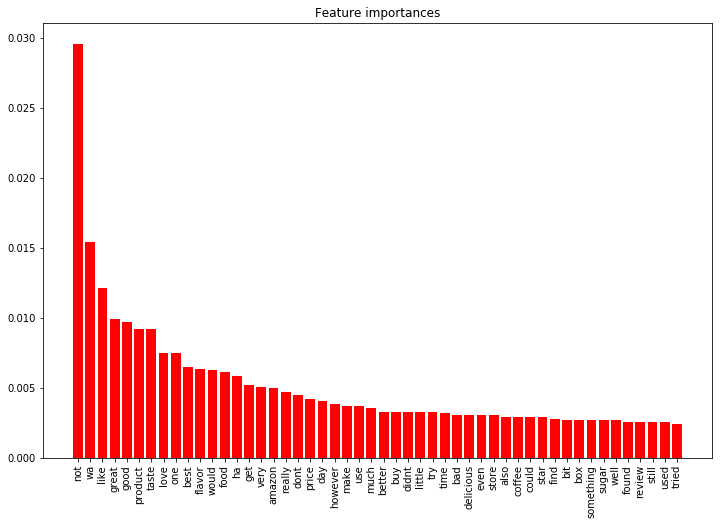

In [39]:
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(len(list_feature[0:50])),list_fval[0:50],
       color="r")
plt.xticks(range(len(list_feature[0:50])), 
           list_feature[0:50],rotation = 90)

#### Tf-Idf:

In [40]:
#TFIDF with (1,2) gram with cleaned data 
#simple cv for train data
#tfidf vec 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = train_df.iloc[:round(train_df.shape[0]*0.70),:]
X_test_cv = train_df.iloc[round(train_df.shape[0]*0.70):,:]
final_counts_train = tf_idf_vect.fit_transform(
        X_train['final_text'].values)
#test
X_test = tf_idf_vect.transform(X_test_cv['final_text'].values)

##### Random Forest

In [27]:
for i in range(1,20):
    model = RF(n_estimators=i,n_jobs=-1,random_state=25)
    model.fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 1 Train Score 0.9434500459527919 Test Score 0.8208065275380512
No of Estimators 2 Train Score 0.9503541727376656 Test Score 0.8015325069302788
No of Estimators 3 Train Score 0.9757178722736545 Test Score 0.8582561849469115
No of Estimators 4 Train Score 0.9874246262132658 Test Score 0.86530414770647
No of Estimators 5 Train Score 0.9842135347784179 Test Score 0.8648464877870181
No of Estimators 6 Train Score 0.9929333572437291 Test Score 0.873659710235891
No of Estimators 7 Train Score 0.9885510300150188 Test Score 0.863421204037868
No of Estimators 8 Train Score 0.9948275089103584 Test Score 0.8727443903969873
No of Estimators 9 Train Score 0.9915323574903051 Test Score 0.861368272399184
No of Estimators 10 Train Score 0.9960828046894263 Test Score 0.8708483707306868
No of Estimators 11 Train Score 0.9935497971352357 Test Score 0.8614205763899786
No of Estimators 12 Train Score 0.9970635045168232 Test Score 0.8696192269470161
No of Estimators 13 Train Score 0.99513012

In [28]:
for i in [150,300,500]:
    model = RF(n_estimators=i,n_jobs=-1,random_state=25)
    model.fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score) VB 
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 150 Train Score 0.9999943960009863 Test Score 0.8560463413358439
No of Estimators 300 Train Score 0.9999943960009863 Test Score 0.8549218055337622
No of Estimators 500 Train Score 0.9999943960009863 Test Score 0.8542810816465296


In [31]:
#random search
param_distributions = {'randomforestclassifier__n_estimators':sp_randint(1,50),
                       'randomforestclassifier__max_depth':sp_randint(10,150)}

model_random_tfidf_rf = RandomizedSearchCV(make_pipeline(TfidfVectorizer(ngram_range=(1,2)),
                                                    RF(n_jobs=-1,random_state=25)),
                                       param_distributions=param_distributions,n_iter=40,
                                       cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_tfidf_rf.fit(train_df['final_text'],train_df.Score)
pickle.dump(model_random_tfidf_rf,open('model_random_tfidf_rf.p','wb'))

In [44]:
model_random_tfidf_rf.grid_scores_[0]

mean: 0.85523, std: 0.01842, params: {'randomforestclassifier__max_depth': 142, 'randomforestclassifier__n_estimators': 27}

In [45]:
dict_scores = []
idx = 0
for i in model_random_tfidf_rf.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['randomforestclassifier__n_estimators'])
    dict_score.append(i[0]['randomforestclassifier__max_depth'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_tfidf_rf.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df1 = pd.DataFrame(dict_scores,columns=['n_estimators','depth',
                'Test_score','Test_std','Train_score'])

In [46]:
scores_df1.sort_values('Test_score',ascending=False)

,n_estimators,depth,Test_score,Test_std,Train_score
17,3,126,0.860801,0.016423,0.916165
36,6,105,0.859692,0.019217,0.912101
2,29,146,0.855562,0.018273,0.928623
3,26,142,0.855554,0.018274,0.925843
0,27,142,0.855230,0.018425,0.926185
38,38,149,0.854565,0.018887,0.930270
31,4,63,0.854518,0.020148,0.891385
37,20,120,0.854099,0.018943,0.912255
10,22,119,0.853595,0.019060,0.911291
12,48,148,0.853573,0.018661,0.929691


In [12]:
#random search
param_distributions = {'randomforestclassifier__n_estimators':
                             sp_randint(1,50)}

model_random_tfidf_rf1 = RandomizedSearchCV(
                   make_pipeline(TfidfVectorizer(ngram_range=(1,2)),
                   RF(n_jobs=-1,random_state=25)),
                   param_distributions=param_distributions,n_iter=20,
                       cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_tfidf_rf1.fit(train_df['final_text'],train_df.Score)
pickle.dump(model_random_tfidf_rf1,open('model_random_tfidf_rf1.p','wb'))

In [15]:
dict_scores = []
idx = 0
for i in model_random_tfidf_rf1.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['randomforestclassifier__n_estimators'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_tfidf_rf1.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['n_estimators',
                'Test_score','Test_std','Train_score'])

In [17]:
scores_df = scores_df.sort_values('n_estimators')

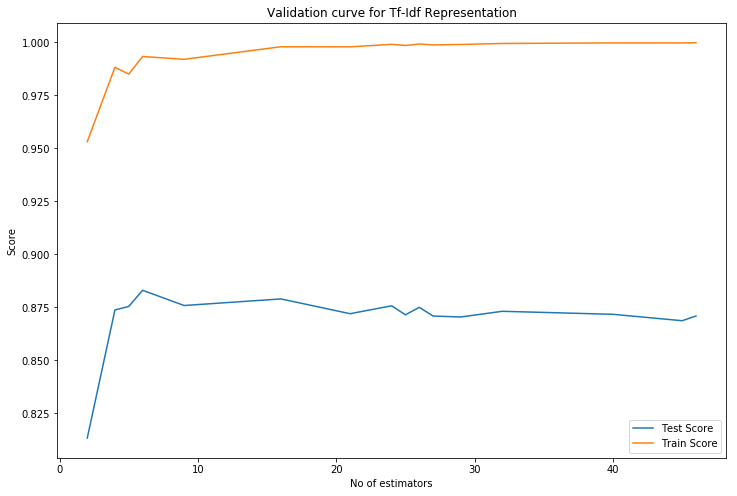

In [21]:
plt.figure(figsize=(12,8))
plt.plot(scores_df.n_estimators,scores_df.Test_score,label='Test Score')
plt.plot(scores_df.n_estimators,scores_df.Train_score,label='Train Score')
plt.title('Validation curve for Tf-Idf Representation')
plt.xlabel('No of estimators')
plt.ylabel('Score')
plt.legend()

In [23]:
scores_df.sort_values('Test_score',ascending=False).head(5)

,n_estimators,Test_score,Test_std,Train_score
10,6,0.883076,0.010823,0.993331
2,16,0.879002,0.011770,0.997926
5,9,0.875895,0.013146,0.992001
3,24,0.875766,0.012165,0.999061
7,5,0.875455,0.013131,0.985027


Got best cv score at n_estimators = 6 at max dept and mean cv score is 0.883076

In [41]:
#test scores
#TFIDF with (1,2) gram with cleaned data 
#tfidf vec 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_counts_train = tf_idf_vect.fit_transform(
        train_df['final_text'].values)
#test
X_test = tf_idf_vect.transform(test_df['final_text'].values)

model = RF(n_estimators=6)
model.fit(final_counts_train,train_df.Score)
#Predicting training data
train_list = model.predict(final_counts_train)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('n_estimators=6')
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

n_estimators=6
Train Score 0.9927624352738114
Test Score 0.8698043953831086
Test Precision 0.8794440336537501
Test Recall 0.9760568690946192
Test ConfusionMatrix [[ 7014 12065]
 [ 2159 88013]]


In [42]:
features = count_vect.get_feature_names()
dict_feature = dict(zip(features,importances))
sorted_feature = dict(sorted(dict_feature.items(), 
                key=operator.itemgetter(1),reverse=True))

In [43]:
#To 100 features to seperate the data using Bag of words with RF
list_feature = list(sorted_feature.keys())[0:100]
list_fval = list(sorted_feature.values())[0:100]
print(list_feature)

['not', 'wa', 'like', 'great', 'good', 'product', 'taste', 'love', 'one', 'best', 'flavor', 'would', 'food', 'ha', 'get', 'very', 'amazon', 'really', 'dont', 'price', 'day', 'however', 'make', 'use', 'much', 'better', 'buy', 'didnt', 'little', 'try', 'time', 'bad', 'delicious', 'even', 'store', 'also', 'coffee', 'could', 'star', 'find', 'bit', 'box', 'something', 'sugar', 'well', 'found', 'review', 'still', 'used', 'tried', 'year', 'bag', 'bought', 'cat', 'chocolate', 'disappointed', 'first', 'ive', 'perfect', 'though', 'wont', 'brand', 'excellent', 'shipping', 'sweet', 'tea', 'thought', 'water', 'ingredient', 'know', 'nice', 'pretty', 'terrible', 'come', 'disappointing', 'doesnt', 'drink', 'dry', 'favorite', 'looking', 'money', 'old', 'ordered', 'say', 'small', 'stick', 'thing', 'unfortunately', 'way', 'work', 'amazing', 'back', 'changed', 'doe', 'high', 'keep', 'long', 'quite', 'smell', 'tasty']


([<matplotlib.axis.XTick at 0x153c7cb19438>,
 <a list of 50 Text xticklabel objects>)

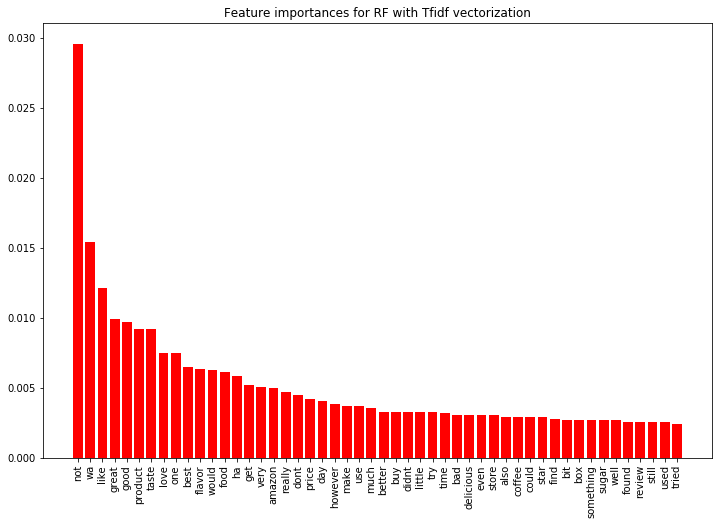

In [45]:
plt.figure(figsize=(12,8))
plt.title("Feature importances for RF with Tfidf vectorization")
plt.bar(range(len(list_feature[0:50])),list_fval[0:50],
       color="r")
plt.xticks(range(len(list_feature[0:50])), 
           list_feature[0:50],rotation = 90)

##### XGBoost:

In [16]:
#base model
model = xgb.XGBClassifier(n_jobs=-1,random_state=25).fit(final_counts_train,X_train.Score)
#train score
train_score = model.score(final_counts_train,X_train.Score)
#test score
test_score = model.score(X_test,X_test_cv.Score)
print('Train Score',train_score)
print('Test Score',test_score)

Train Score 0.9028826970926453
Test Score 0.8865003399759401


In [17]:
for i in range(0,100,10):
    model = xgb.XGBClassifier(n_estimators=i,n_jobs=-1)
    model = model.fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('No of Estimators',i,'Train Score',train_score,'Test Score',test_score)

No of Estimators 0 Train Score 0.1399878953621304 Test Score 0.17065484596474711
No of Estimators 10 Train Score 0.8626291721772656 Test Score 0.8329410534023746
No of Estimators 20 Train Score 0.8673925713389075 Test Score 0.8399105601757414
No of Estimators 30 Train Score 0.8716347985922754 Test Score 0.8461347350802866
No of Estimators 40 Train Score 0.8771883616148484 Test Score 0.8529865578743658
No of Estimators 50 Train Score 0.8829885005940239 Test Score 0.8608190804958419
No of Estimators 60 Train Score 0.8878079397458026 Test Score 0.8670955593911815
No of Estimators 70 Train Score 0.892061374997198 Test Score 0.8727966943877817
No of Estimators 80 Train Score 0.8962027302683194 Test Score 0.8783932214027931
No of Estimators 90 Train Score 0.8999910336015781 Test Score 0.8829567445996129


In [11]:
from xgboost import XGBClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.pipeline import make_pipeline
np.random.seed(25)
param_distributions = {'xgbclassifier__n_estimators':sp_randint(200,900),
                       'xgbclassifier__max_depth':sp_randint(3,9),
                       'xgbclassifier__learning_rate':uniform(0,1),
                       'xgbclassifier__subsample':uniform(0,1),
                       'xgbclassifier__reg_alpha':uniform(0,1),
                       'xgbclassifier__reg_lambda':uniform(0,1),
                      'xgbclassifier__colsample_bylevel':uniform(0.7,0.3)}

model_random_tfidf_xgb = RandomizedSearchCV(make_pipeline(TfidfVectorizer(ngram_range=(1,2)),
                                                    XGBClassifier(n_jobs=-1,random_state=25)),
                                       param_distributions=param_distributions,n_iter=15,
                                       cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_tfidf_xgb.fit(train_df['final_text'],train_df.Score)
pickle.dump(model_random_tfidf_xgb,open('model_random_tfidf_xgb.p','wb'))

In [14]:
dict_scores = []
idx = 0
for i in model_random_tfidf_xgb.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['xgbclassifier__n_estimators'])
    dict_score.append(i[0]['xgbclassifier__max_depth'])
    dict_score.append(i[0]['xgbclassifier__subsample'])
    dict_score.append(i[0]['xgbclassifier__colsample_bylevel'])
    dict_score.append(i[0]['xgbclassifier__learning_rate'])
    dict_score.append(i[0]['xgbclassifier__reg_alpha'])
    dict_score.append(i[0]['xgbclassifier__reg_lambda'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_tfidf_xgb.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['n_estimators','depth',
         'subsample','colsample_bylevel','learning_rate','reg_alpha',
              'reg_lambda','Test_score','Test_std','Train_score'])

In [16]:
scores_df.sort_values('Test_score',ascending=False).head(3)

,n_estimators,depth,subsample,colsample_bylevel,learning_rate,reg_alpha,reg_lambda,Test_score,Test_std,Train_score
2,759,3,0.907128,0.859582,0.406806,0.362060,0.305770,0.944274,0.003011,0.983090
3,503,7,0.849676,0.776976,0.231515,0.477546,0.631773,0.942919,0.004053,0.991016
5,371,5,0.745284,0.900884,0.456069,0.525819,0.559242,0.940904,0.003930,0.986590


Got best cv score at n_estimators = 759, max_depth = 3,subample = 0.907128, colsample_bylevel = 0.859582, learning rate = 0.406806, reg_alpha = 0.362060, reg_lambda = 0.305770 and mean test cv is	0.944274

In [46]:
#test scores
#TFIDF with (1,2) gram with cleaned data 
#tfidf vec 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_counts_train = tf_idf_vect.fit_transform(
        train_df['final_text'].values)
#test
X_test = tf_idf_vect.transform(test_df['final_text'].values)

model = xgb.XGBClassifier(max_depth=3,learning_rate=0.406806,
                           n_estimators=759,n_jobs=-1,
                          subsample=0.907128,colsample_bylevel=0.859582,
                            reg_alpha=0.362060,reg_lambda=0.305770)
model.fit(final_counts_train,train_df.Score)
#Predicting training data
train_list = model.predict(final_counts_train)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('''max_depth=3,learning_rate=0.406806,
         n_estimators=759,n_jobs=-1,
         subsample=0.907128,colsample_bylevel=0.859582,
         reg_alpha=0.362060,reg_lambda=0.305770''')
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

max_depth=3,learning_rate=0.406806,
         n_estimators=759,n_jobs=-1,
         subsample=0.907128,colsample_bylevel=0.859582,
         reg_alpha=0.362060,reg_lambda=0.305770
Train Score 0.9708889063235525
Test Score 0.9481926938883855
Test Precision 0.9579801877181193
Test Recall 0.9802266779044493
Test ConfusionMatrix [[15202  3877]
 [ 1783 88389]]


In [47]:
import operator
importances = model.feature_importances_
features = count_vect.get_feature_names()
dict_feature = dict(zip(features,importances))
sorted_feature = dict(sorted(dict_feature.items(), 
                    key=operator.itemgetter(1),reverse=True))

In [48]:
#To 100 features to seperate the data using Bag of words with RF
list_feature = list(sorted_feature.keys())[0:100]
list_fval = list(sorted_feature.values())[0:100]
print(list_feature)

['smartdogs', 'ovaltine', 'ambivalence', 'minuscule', 'grackle', 'everwhere', 'gent', 'advertizer', 'globule', 'ob', 'radish', 'bentadril', 'disapproving', 'lift', 'prima', 'subito', 'taam', 'bothering', 'brine', 'caducity', 'crass', 'domesticate', 'goldenflax', 'groundclear', 'mcgee', 'nectar', 'overrun', 'pimiento', 'reshipment', 'soaping', 'therefor', 'twixt', 'undercut', 'untraceable', 'vegecat', 'warns', 'wildeberryaki', 'aa', 'aachen', 'aachener', 'aaf', 'aagghh', 'aah', 'aahhyaa', 'aahing', 'aahs', 'aammaazziinngg', 'aap', 'aardvark', 'aargh', 'aaron', 'aarp', 'aarrgh', 'aarrghh', 'aauw', 'ab', 'aback', 'abacus', 'abada', 'abalone', 'abamectin', 'abandon', 'abandoned', 'abandoning', 'abash', 'abated', 'abates', 'abattoir', 'abb', 'abba', 'abbas', 'abbazabba', 'abbey', 'abbie', 'abbondanza', 'abbot', 'abbott', 'abbreviated', 'abbreviating', 'abbreviation', 'abby', 'abc', 'abcstores', 'abd', 'abdomen', 'abdominal', 'abduct', 'abe', 'abel', 'aberdeen', 'aberfoyle', 'abernook', 'abe

([<matplotlib.axis.XTick at 0x153cd6c32da0>,
 <a list of 50 Text xticklabel objects>)

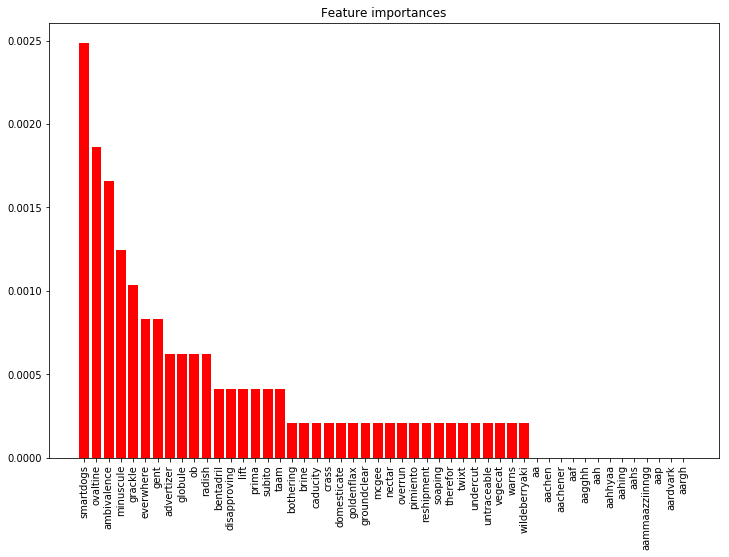

In [49]:
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(len(list_feature[0:50])),list_fval[0:50],
       color="r")
plt.xticks(range(len(list_feature[0:50])), 
           list_feature[0:50],rotation = 90)

#### Conclusions:<br>
1. For RF with Avg Word2Vec Representation got good cv score at n_ectimators = 20 and depth = 25 with mean cv of 0.896263.
    *  Train Score 0.997889533971442
    *  Test Score 0.8889438082946609
    *  Test Precision 0.8970036119448542
    *  Test Recall 0.9777092667346848
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 8956 & 10123 &  \\
    & 2010 & 88162 & 
    \end{bmatrix}
    \end{equation}
<br>
2. For XGBoost with Avg Word2Vec representation got best cv at no of estimators = 900, depth = 5, learning rate = 0.52 and subsample = 0.93 with mean cv score of 0.939139.
    *  Train Score 1.0
    *  Test Score 0.9303164273095899
    *  Test Precision 0.9402160582696143
    *  Test Recall 0.9777425364858271
    *  Test ConfusionMatrix 
    \begin{equation}
    \begin{bmatrix}
    & 13473 & 5606 &  \\
    & 2007 & 88165 & 
    \end{bmatrix}
    \end{equation}
<br>
3. For RF with Tf-Idf Word2Vec representation got best cv at at 56 and test cv is 0.884962.
    *  Train Score 0.9796524399811706
    *  Test Score 0.8709485496700259
    *  Test Precision 0.8726985900036254
    *  Test Recall 0.9877234618285056
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 6087 & 12992 &  \\
    & 1107 & 89065 & 
    \end{bmatrix}
    \end{equation}
<br>
4. For XGBoost with Tf-Idf Word2Vec representation got best cv at n_estimators = 884, depth = 4, subsample = 0.994481, colsample_bylevel=0.791814, learning_rate = 0.229976, reg_alpha = 0.998268, reg_lambda = 0.150014 and Test_score is 0.920558.
    *  Train Score 0.9620547622783618
    *  Test Score 0.9055477753064045
    *  Test Precision 0.9101124749627652
    *  Test Recall 0.9826110100696447
    *  Test ConfusionMatrix 
    \begin{equation}
    \begin{bmatrix}
    & 10328 & 8751 &  \\
    & 1568 & 88604 & 
    \end{bmatrix}
    \end{equation}
<br>
5. For RF with Bag of Words representation got best cv at no of estimators = 28, depth = 483 and Test cv score is 0.891749.
    *  Train Score 0.9995606464773262
    *  Test Score 0.8887058242029822
    *  Test Precision 0.8856493153393643
    *  Test Recall 0.9934236791908797
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 7513 & 11566 &  \\
    & 593 & 89579 & 
    \end{bmatrix}
    \end{equation}
<br>
6. For XGBoost with Bag of Words representation got best cv at n_estimators = 1240, depth = 3, subsample = 0.660874, colsample_bylevel=0.761028, learning_rate = 0.259216, reg_alpha = 0.676561, reg_lambda = 0.021376 and Test_score is 0.937136.
    *  Train Score 0.956825670798682
    *  Test Score 0.9375749421057931
    *  Test Precision 0.949588987896179
    *  Test Recall 0.9761899480991882
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 14406 & 4673 &  \\
    & 2147 & 88025 & 
    \end{bmatrix}
    \end{equation}
<br>
7. For RF with Tf-Idf vectorization got best cv at n_estimators = 6 , max dept and mean cv score is 0.883076.
    *  Train Score 0.9927624352738114
    *  Test Score 0.8698043953831086
    *  Test Precision 0.8794440336537501
    *  Test Recall 0.9760568690946192
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 7014 & 12065 &  \\
    & 2159 & 88013 & 
    \end{bmatrix}
    \end{equation}
<br>
8. For XGBoost wit Tf-Idf vectorization got best cv at n_estimators = 759, max_depth = 3,subample = 0.907128, colsample_bylevel = 0.859582, learning rate = 0.406806, reg_alpha = 0.362060, reg_lambda = 0.305770 and mean test cv is 0.944274.
    *  Train Score 0.9708889063235525
    *  Test Score 0.9481926938883855
    *  Test Precision 0.9579801877181193
    *  Test Recall 0.9802266779044493
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 15202 & 3877 &  \\
    & 1783 & 88389 & 
    \end{bmatrix}
    \end{equation}
<br>


    